In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
import scipy.stats as st
import datetime
from astropy.time import Time
import copy

mpl.rcParams.update({'font.size': 14})

In [13]:
def calc_solar_cycle_phase(time):
    """
    Function to calculate the solar cycle number, solar cycle phase (between 0-2pi),and solar cycle state (rising=+1,
    falling =-1) for an array of times, provided as julian dates. Dates taken from Wikipedia, could be improved.
    :param time: An array of julian dates
    :return: sc_num     : Solar cycle number
             sc_phase   : Solar cycle phase
             sc_state   : Solar cycle state
             sc_max     : Solar cycle maximum time
             hale_num   : Hale cycle number, assuming polar fields flip 1 year after sunspot maximum.
             hale_phase : Phase of the Hale cycle, assuming polar fields flip 1 year after sunspot maximum.
    """
    # Get start times and max times in julian dates
    start_times_list = ['1744-01-01', '1755-02-01', '1766-06-01', '1775-06-01', '1784-09-01', '1798-04-01',
                        '1810-07-01', '1823-05-01', '1833-11-01', '1843-07-01', '1855-12-01',
                        '1867-03-01', '1878-12-01', '1890-03-01', '1902-01-01', '1913-07-01',
                        '1923-08-01', '1933-09-01', '1944-02-01', '1954-04-01', '1964-10-01',
                        '1976-03-01', '1986-09-01', '1996-08-01', '2008-12-01', '2019-12-01']

    max_times_list = ['1748-01-01', '1761-06-01', '1769-09-01', '1778-05-01', '1788-02-01', '1805-02-01',
                      '1816-05-01', '1829-11-01', '1837-03-01', '1848-02-01', '1860-02-01',
                      '1870-08-01', '1883-12-01', '1894-01-01', '1906-02-01', '1917-08-01',
                      '1928-04-01', '1937-04-01', '1947-05-01', '1958-03-01', '1968-11-01',
                      '1979-12-01', '1989-11-01', '2001-11-01', '2014-04-01', '2024-01-01']

    start_times = pd.to_datetime(start_times_list).to_julian_date()
    max_times = pd.to_datetime(max_times_list).to_julian_date()
    # Calculate cycle lengths
    cycle_length = start_times[1:] - start_times[0:-1]
    # Throw away last cycle start time, so lengths tally.
    start_times = start_times[0:-1]
    max_times = max_times[0:-1]
    # Calculate corresponding solar cycle numbers.
    sc = np.arange(0, len(start_times), dtype='int')
    # Workout sc index of each time.
    idt = np.zeros(time.shape, dtype='int')
    for i, t in enumerate(time):
        idt[i] = np.argwhere(start_times <= t)[-1]

    sc_num = sc[idt]
    sc_phase = 2.0 * np.pi * (time - start_times[idt]) / cycle_length[idt]

    # Get the phase of the maximum for every point.
    sc_phase_max = 2.0 * np.pi * (max_times[idt] - start_times[idt]) / cycle_length[idt]

    # Compute whether in active or quiet phase
    sc_state = -1*np.ones(time.shape)
    # Avg cycle is 11 years and avg active period is 4 years centered on max
    # So assume all active periods are +/- 1.1 rad around max phase
    id_active = (sc_phase >= (sc_phase_max - 1.1)) & (sc_phase <= (sc_phase_max + 1.1))
    sc_state[id_active] = 1

    # Compute whether rising or falling part of cycle
    sc_risefall = np.ones(time.shape)
    sc_risefall[time > max_times[idt]] = -1

    sc_max_phase = 2.0 * np.pi * (max_times[idt] - start_times[idt]) / cycle_length[idt]
    return sc_num, sc_phase, sc_state, sc_risefall

def LoadSSN():

    # Dowload from http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv
    filepath = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/SN_m_tot_V2.0.csv"

    col_specification =[(0, 4), (5, 7), (8,16),(17,23),(24,29),(30,35)]
    ssn_df=pd.read_fwf(filepath, colspecs=col_specification,header=None)
    dfdt=np.empty_like(ssn_df[0], dtype=datetime.datetime)
    dfTime=np.empty_like(ssn_df[0], dtype=Time)

    for i in range(0,len(ssn_df)):
        date_string = str(int(ssn_df[0][i])) + '-' + str(int(ssn_df[1][i])) + '-15'

        dfdt[i] = datetime.datetime(int(ssn_df[0][i]),int(ssn_df[1][i]),15)
        dfTime[i] = Time(date_string, format='iso')

    #replace the index with the datetime objects
    ssn_df['datetime']=dfdt
    ssn_df['time'] = dfTime
    ssn_df["fracyear"]= ssn_df.apply(lambda row: row["time"].decimalyear, axis=1)

    ssn_df['ssn']=ssn_df[3]

    ssn_df['jd'] = ssn_df.apply(lambda row: row["time"].jd, axis=1)

    #delete the unwanted columns
    ssn_df.drop(0,axis=1,inplace=True)
    ssn_df.drop(1,axis=1,inplace=True)
    ssn_df.drop(2,axis=1,inplace=True)
    ssn_df.drop(3,axis=1,inplace=True)
    ssn_df.drop(4,axis=1,inplace=True)
    ssn_df.drop(5,axis=1,inplace=True)

    #add the 13-month running smooth
    window = 13*30
    temp = ssn_df.rolling(str(window)+'D', on='datetime').mean()
    ssn_df['smooth'] = np.interp(ssn_df['jd'],temp['jd'],temp['ssn'],
                                              left =np.nan, right =np.nan)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < ssn_df['jd'].loc[0] + window/2
    ssn_df.loc[mask, 'smooth'] = np.nan

    #add in a solar activity index, which normalises the cycle magnitude
    #approx solar cycle length, in months
    nwindow = int(11*12)
    #find maximum value in a 1-solar cycle bin centred on current time
    ssn_df['rollingmax'] = ssn_df.rolling(nwindow, center = True).max()['smooth']
    #fill the max value at the end of the series
    fillval_end = ssn_df['rollingmax'].dropna().values[-1]
    fillval_start = ssn_df['rollingmax'].dropna().values[0]
    ssn_df['rollingmax'] = ssn_df['rollingmax'].fillna(fillval_end)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < (ssn_df['jd'].loc[0] + 11*365.25/2)
    ssn_df.loc[mask, 'rollingmax'] = fillval_start
    #create a Solar Activity Index, as SSN normalised to the max smoothed value in
    #1-sc window centred on current tim
    ssn_df['sai'] = ssn_df['smooth']/ssn_df['rollingmax']
    return ssn_df

In [14]:
# load in the CME transit time data
data_path = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/output/CME_transit_data.hdf5"
data = h5py.File(data_path, 'r')

In [111]:
cr_keys = data.keys()
# Make array of CR numbers from the keys -  this is discontinuous.
cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
cr_time = carrington_rotation_time(cr_nums+0.5)

cr_nums_pad = np.arange(cr_nums.min(), cr_nums.max() + 1, 1)
cr_time_pad = carrington_rotation_time(cr_nums_pad + 0.5)
vsw_bc = []

for cr_num in cr_nums_pad:
    cr_tag = "CR_{}".format(cr_num)

    if cr_tag in cr_keys:
        # Get BC variability
        vsw_bc.append(data[cr_tag + '/vr_in'][:])
    else:
        vsw_bc.append(np.nan*np.ones(360))

vsw = np.array(vsw_bc)
print(vsw.shape)

lons = np.arange(0,360,1)

(640, 360)


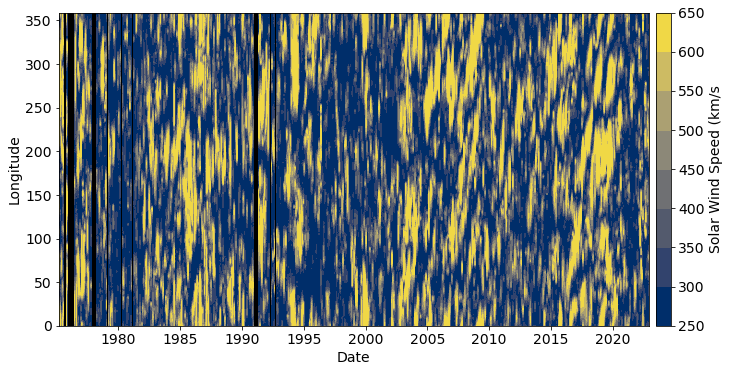

In [122]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
ax.set_facecolor('k')
levels = np.arange(250, 700, 50)
cmap = copy.copy(mpl.cm.get_cmap('cividis'))
cmap.set_bad(color='k', alpha=1)

cnt = ax.contourf(cr_time_pad.datetime, lons, vsw.T, levels=levels, cmap=cmap, vmin=levels[0], vmax=levels[-1])
ax.set_xlabel('Date')
ax.set_ylabel('Longitude')

cbar = fig.colorbar(cnt, ax=ax, pad=0.01)
cbar.ax.set_ylabel('Solar Wind Speed (km/s')

fig.subplots_adjust(left=0.075, bottom=0.11, right=1.05, top=0.98)
fig.savefig("MAS_Vsw_equator_timeseries.png")

In [40]:
cr_keys = data.keys()
# Make array of CR numbers from the keys -  this is discontinuous.
cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
cr_time = carrington_rotation_time(cr_nums+0.5)

for cme_type in ["cme_average", "cme_fast"]:

    transit_avg = np.zeros(len(cr_nums))
    transit_var = np.zeros(len(cr_nums))
    vsw_mas_var = np.zeros(len(cr_nums))

    for i, (cr_key, cr_data) in enumerate(data.items()):

        # Get BC variability
        vsw_mas_var[i] = cr_data['vr_in_std'][()]

        # Convert transits from days to hours
        transits = 24*cr_data[cme_type + '/t_transit'][:]
        transit_avg[i] = np.nanmedian(transits)
        transit_var[i] = st.iqr(transits, nan_policy="omit")

    id_good = np.isfinite(transit_var) & np.isfinite(transit_avg)
    cr_nums_sub = cr_nums[id_good]
    cr_time_sub = cr_time[id_good]
    transit_avg = transit_avg[id_good]
    transit_var = transit_var[id_good]
    vsw_mas_var = vsw_mas_var[id_good]

    df = pd.DataFrame({'cr_num':cr_nums_sub, 'datetime':cr_time_sub.datetime, 'jd':cr_time_sub.jd, 'avg':transit_avg, 'iqr':transit_var, 'vsw_var':vsw_mas_var})
    if cme_type == 'cme_average':
        cme_avg = df.copy()
    elif cme_type == 'cme_fast':
        cme_fst = df.copy()

    del df

# Load SSN and SAI
ssn = LoadSSN()

# Interpolate SAI onto the CME series
cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [ ]:
fig, ax = plt.subplots(4,1, figsize=(10,10), facecolor='white')

ax[0].plot(ssn['datetime'], ssn['ssn'], 'k-')
ax[1].plot(ssn['datetime'], ssn['sai'], 'k-')

for a, cme, label in zip(ax[2:], [cme_avg, cme_fst], ['Average CME', 'Fast CME']):
    y1 = cme['avg'] - cme['iqr']/2
    y2 = cme['avg'] + cme['iqr']/2
    a.plot(cme_avg['datetime'], cme['avg'], 'k-', zorder=2)
    a.fill_between(cme_avg['datetime'], y1, y2, color='b', alpha=0.5, zorder=1)
    a.text(0.02, 0.925, label, transform=a.transAxes, fontsize=14)

for a in ax:
    a.set_xlim(cme_avg['datetime'].min(), cme_avg['datetime'].max())

for a in ax[:-1]:
    a.set_xticklabels([])

ax[0].set_ylim(0,300)

ax[-1].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('SSN', fontsize=14)
ax[1].set_ylabel('SAI', fontsize=14)
ax[2].set_ylabel('Transit time (hours)', fontsize=14)
ax[3].set_ylabel('Transit time (hours)', fontsize=14)

fig.subplots_adjust(left=0.08, bottom=0.06, right=0.99, top=0.99, hspace=0.025)
fig.savefig('ssn_sai_cme_timeseries.png')

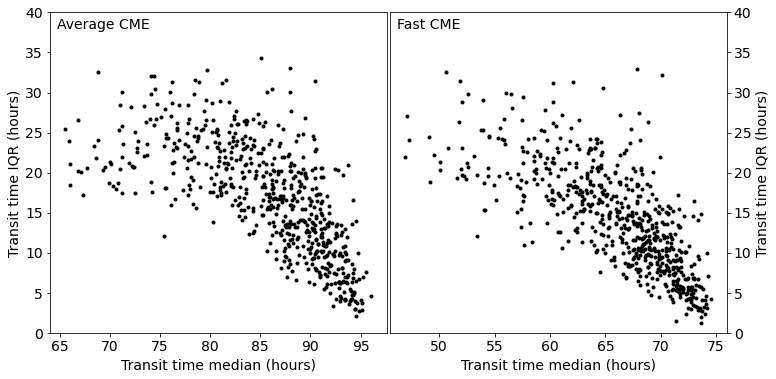

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
for a, cme, label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):
    a.plot(cme['avg'], cme['iqr'], 'k.')
    a.set_xlabel('Transit time median (hours)', fontsize=14)
    a.set_ylabel('Transit time IQR (hours)', fontsize=14)
    a.set_ylim(0,40)
    a.text(0.02, 0.95, label, transform=a.transAxes, fontsize=14)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.01)
fig.savefig('cme_transit_time_median_iqr_scatter.png')

Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


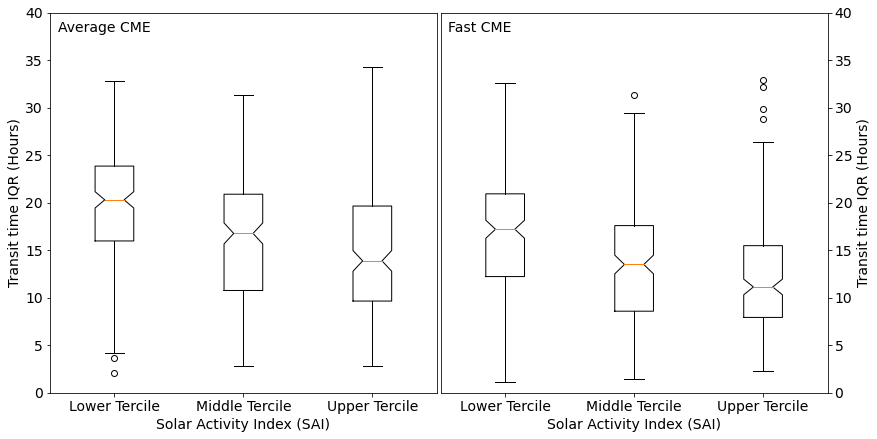

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

    terciles = cme['sai'].quantile([0.333,0.666]).values

    id_low = cme['sai'] <= terciles[0]
    id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
    id_high = cme['sai'] > terciles[1]

    print(cme_label)
    print('Total samples: {}'.format(len(id_low)))
    print("Samples in low tercile: {}".format(np.sum(id_low)))
    print("Samples in mid tercile: {}".format(np.sum(id_mid)))
    print("Samples in high tercile: {}".format(np.sum(id_high)))

    activity_levels = ['Low', 'Medium', 'High']
    colors = ['r', 'b', 'm']
    activity_cols = {a:c for a,c in zip(activity_levels, colors)}
    x = np.arange(0, 50, 0.01)


    boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
    labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
    a.boxplot(boxplot_data, notch=True, labels=labels)
    a.text(0.02, 0.95, cme_label, transform=a.transAxes)

    a.set_xlabel('Solar Activity Index (SAI)')
    a.set_ylabel('Transit time IQR (Hours)')
    a.set_ylim(0,40)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
fig.savefig('transit_time_iqr_sai_boxplot.png')

Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


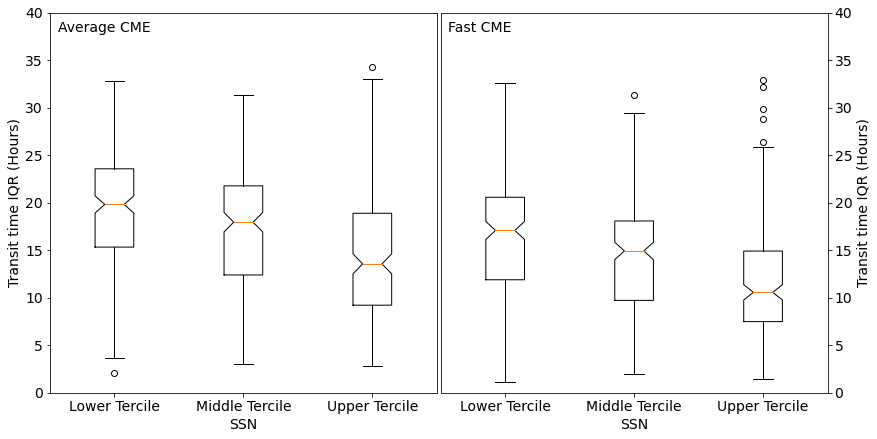

In [43]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

    terciles = cme['ssn'].quantile([0.333,0.666]).values

    id_low = cme['ssn'] <= terciles[0]
    id_mid = (cme['ssn'] > terciles[0]) & (cme['ssn'] <= terciles[1])
    id_high = cme['ssn'] > terciles[1]

    print(cme_label)
    print('Total samples: {}'.format(len(id_low)))
    print("Samples in low tercile: {}".format(np.sum(id_low)))
    print("Samples in mid tercile: {}".format(np.sum(id_mid)))
    print("Samples in high tercile: {}".format(np.sum(id_high)))

    activity_levels = ['Low', 'Medium', 'High']
    colors = ['r', 'b', 'm']
    activity_cols = {a:c for a,c in zip(activity_levels, colors)}
    x = np.arange(0, 50, 0.01)


    boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
    labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
    a.boxplot(boxplot_data, notch=True, labels=labels)
    a.text(0.02, 0.95, cme_label, transform=a.transAxes)

    a.set_xlabel('SSN')
    a.set_ylabel('Transit time IQR (Hours)')
    a.set_ylim(0,40)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
fig.savefig('transit_time_iqr_ssn_boxplot.png')

Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


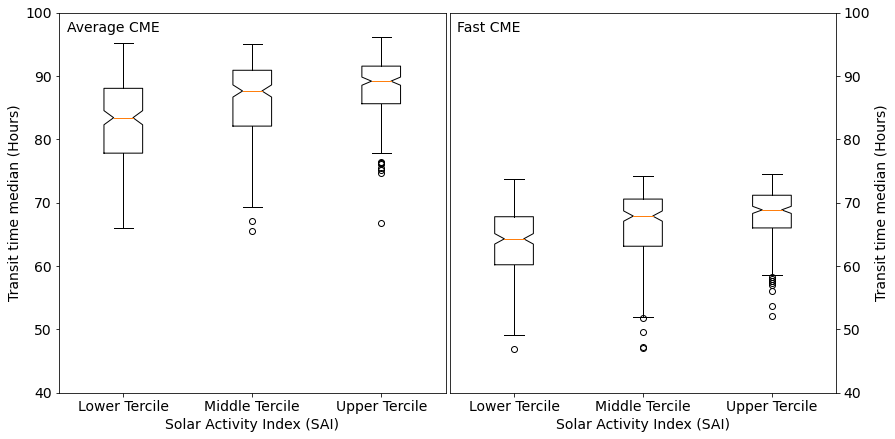

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

    terciles = cme['sai'].quantile([0.333,0.666]).values

    id_low = cme['sai'] <= terciles[0]
    id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
    id_high = cme['sai'] > terciles[1]

    print(cme_label)
    print('Total samples: {}'.format(len(id_low)))
    print("Samples in low tercile: {}".format(np.sum(id_low)))
    print("Samples in mid tercile: {}".format(np.sum(id_mid)))
    print("Samples in high tercile: {}".format(np.sum(id_high)))

    activity_levels = ['Low', 'Medium', 'High']
    colors = ['r', 'b', 'm']
    activity_cols = {a:c for a,c in zip(activity_levels, colors)}
    x = np.arange(0, 50, 0.01)


    boxplot_data = [cme.loc[id_low, 'avg'], cme.loc[id_mid, 'avg'], cme.loc[id_high, 'avg']]
    labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
    a.boxplot(boxplot_data, notch=True, labels=labels)
    a.text(0.02, 0.95, cme_label, transform=a.transAxes)

    a.set_xlabel('Solar Activity Index (SAI)')
    a.set_ylabel('Transit time median (Hours)')

ax[0].set_ylim(40, 100)
ax[1].set_ylim(40, 100)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
fig.savefig('transit_time_avg_sai_boxplot.png')